In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

%matplotlib inline

# started 18.53
# finished 20.18


In [2]:
trans = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.FashionMNIST('day1/data', 
                                            download=True, 
                                            transform=trans)

dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: day1/data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [3]:
GPU = True

if not torch.cuda.is_available():
    print('no GPU detected, check CUDA install')
    GPU = False
    
if GPU:
    print('we have CUDA!')

batch_size = 128
learning_rate = 1e-3

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

we have CUDA!


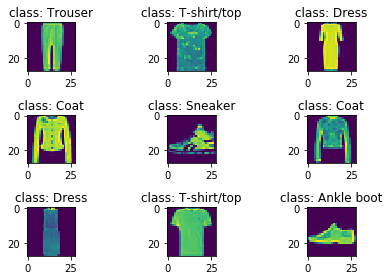

In [4]:
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
           'Sandal','Shirt','Sneaker','Bag','Ankle boot']

fig, axes = plt.subplots(3,3)
for ax in axes.ravel():
    r= iter(dataloader).next()
    ax.imshow(r[0].numpy()[1].reshape(28,28))
    ax.set_title('class: '+classes[r[1].numpy()[1]])
plt.tight_layout()

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input_layer = nn.Linear(784, 400)
        self.mu = nn.Linear(400, 20)
        self.sigma = nn.Linear(400, 20)
        
        self.upscale_sample = nn.Linear(20, 400)
        self.output_layer = nn.Linear(400, 784)
        
    def encode(self, x):
        x = F.relu(self.input_layer(x))
        return self.mu(x), self.sigma(x)
    
    def parametric(self, mu, sigma):
        # A gaussian with
        # mu mean between 0 and inf
        # sigma std between 0 and inf
        
        std = sigma.exp()
        if GPU:
            sample = torch.cuda.FloatTensor(mu.size()).normal_()
        else:
            sample = torch.FloatTensor(mu.size()).normal_()
            
        sample = Variable(sample)
        return sample.mul(std).add(mu)
    
    def decode(self, sample):
        x = F.relu(self.upscale_sample(sample))
        return F.sigmoid(self.output_layer(x))
    
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        sample = self.parametric(mu, sigma)
        return self.decode(sample), mu, sigma

In [6]:
model = VAE()

if GPU:
    model.cuda()

In [7]:
def loss_function(reconstructed, ground_truth, mu, sigma):
    image_loss = nn.MSELoss(reduction='sum')(reconstructed, ground_truth)
    KL_divergence_loss = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    return image_loss, KL_divergence_loss


optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
epochs = 100

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_id, data in enumerate(dataloader):
        img, _ = data
        # reshape
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if GPU:
            img = img.cuda()
        
        optimizer.zero_grad()
        
        batch, mu, sigma = model(img)
        loss_im, loss_kl = loss_function(batch, img, mu, sigma)
        loss = loss_im+ loss_kl
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data.item()
        
        if batch_id % 200 == 0:
            print(loss_im.item(), loss_kl.item())
       
    print('====> Epoch: {} Average loss: {:.4f}'.format(
    epoch, train_loss / len(dataloader.dataset)))

C:\Users\tofed\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


141570.53125 76.30748748779297
62158.796875 923.8842163085938
63685.78125 899.8069458007812
====> Epoch: 0 Average loss: 512.2761
61691.83203125 912.9075927734375
62547.3046875 809.7001342773438
61067.2265625 872.2086181640625
====> Epoch: 1 Average loss: 486.8415
61176.6796875 753.4815063476562
62534.49609375 927.3240966796875
59924.6484375 840.8082275390625
====> Epoch: 2 Average loss: 482.3947
58790.375 865.68408203125
62306.609375 898.2361450195312
59934.0703125 811.5535888671875
====> Epoch: 3 Average loss: 480.0275
61610.44921875 969.914794921875
60002.09375 823.1473999023438
59961.3203125 844.6142578125
====> Epoch: 4 Average loss: 478.5840
60670.8515625 872.430908203125
62622.671875 822.82080078125
60850.546875 871.635009765625
====> Epoch: 5 Average loss: 477.5555
61396.25390625 796.1622314453125
60837.7578125 886.8209838867188
60856.15625 830.3515625
====> Epoch: 6 Average loss: 476.8086
60092.421875 871.1528930664062
61904.23828125 834.7747192382812
59614.4453125 880.1639404

60498.4296875 873.8518676757812
60496.08984375 923.9122314453125
====> Epoch: 62 Average loss: 472.1891
58812.0625 926.78466796875
60441.9296875 915.5458984375
60167.640625 829.7271728515625
====> Epoch: 63 Average loss: 472.1690
58135.98828125 879.1986083984375
59465.75 947.0660400390625
58465.21875 917.1665649414062
====> Epoch: 64 Average loss: 472.1643
59277.19140625 876.5657958984375
60768.25390625 948.166259765625
60035.55859375 875.0403442382812
====> Epoch: 65 Average loss: 472.1624
59363.6875 929.8663330078125
59200.6953125 1000.7708740234375
59084.4921875 923.8638305664062
====> Epoch: 66 Average loss: 472.1569
61795.9453125 835.1170043945312
58927.375 862.750732421875
59474.21875 937.945556640625
====> Epoch: 67 Average loss: 472.1383
58562.25 889.0374145507812
58927.2890625 909.1109008789062
59980.18359375 962.0538330078125
====> Epoch: 68 Average loss: 472.1258
60098.2734375 881.295166015625
59651.36328125 878.0264892578125
61031.71484375 933.5459594726562
====> Epoch: 69 

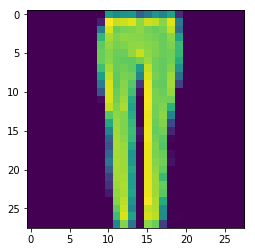

In [51]:
ev_img = iter(dataloader).next()[0].numpy()[1].reshape(28,28)
plt.imshow(ev_img)
ev_img_r = ev_img.ravel()

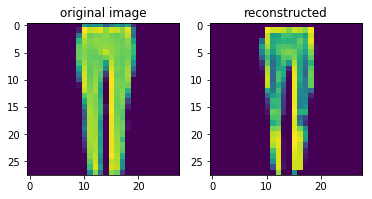

In [52]:
model.eval()
ev_mu, ev_sigma = model.encode(torch.from_numpy(ev_img_r).cuda())
ev_param_tensor = model.parametric(ev_mu,ev_sigma)
ev_out = model.decode(ev_param_tensor).cpu().detach().numpy().reshape(28,28)

fig, ax = plt.subplots(1,2)
ax[0].set_title('original image')
ax[0].imshow(ev_img)
ax[1].set_title('reconstructed')
ax[1].imshow(ev_out)

In [29]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def slide_f(x):
    plt.figure(figsize=(2,2))
    ev_mu_sl = ev_mu.add(x)
    ev_param_tensor = model.parametric(ev_mu_sl,ev_sigma)
    ev_out = model.decode(ev_param_tensor).cpu().detach().numpy().reshape(28,28)
    plt.imshow(ev_out)


interact(slide_f, x=(0, 3.0, 0.02))

interactive(children=(FloatSlider(value=1.5, description='x', max=3.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.slide_f(x)>

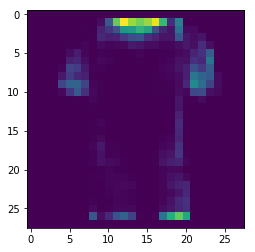

In [105]:
loss_function(torch.cuda.FloatTensor(size=(10,)),
              torch.cuda.FloatTensor(size=(10,)),
              torch.cuda.FloatTensor(size=(10,)),
              torch.cuda.FloatTensor(size=(10,)))

tensor([ 1.7917, -0.7227, -1.2550,  1.2417,  0.1452,  1.0884, -1.7864, -0.7155,
        -1.4950, -1.2023], device='cuda:0')

In [40]:
28*28

784

In [119]:
torch.FloatTensor(size=(10,)).mul_(.1).sub_(1).exp_().numpy()

array([       inf, 0.36787945,        inf, 0.36787945, 0.36787945,
       0.36787945,        nan,        nan, 0.36787945, 0.36787945],
      dtype=float32)